# 3c: Regional glacier runoff and precipitation
- creates additional figure with RGI region aggregated glacier runoff and near-glacier precipitation
- this figure is currently not used, as we replaced it with Supplementary Figs. 6-8 (of 3a_basin_stats.ipynb) that show all 60 glaciated basins

In [1]:
# updated script version for flattening gfdl-esm2m overshoot stabilisation scenarios from university of Bern 
from oggm import utils
import json
import oggm
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
# get the correct colors for the different scenarios
from analysis_func import (color_scenario, label_scenario, provide_reg_full_name_dict, color_scenario_poster, scenario_ls,
                           find_largest_continuous_span,get_basin_trough_water_stats, d_reg_num_name)
palette = sns.color_palette(color_scenario.values())

# get the dataset where coordinates of glaciers are stored
frgi = utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5')
#frgi = '/home/users/lschuster/glacierMIP/rgi62_stats.h5'
odf = pd.read_hdf(frgi, index_col=0)
odf['coords'] = [(lon,lat) for lon,lat in zip(odf['CenLon'],odf['CenLat'])]

In [2]:
# climate datata
pd_clim_all= pd.read_csv('../data/annual_glob_rgi_reg_basin_temp_precip_timeseries_oversh_stab.csv', 
                         index_col=['Unnamed: 0'])
pd_clim_all['precip_51yr_avg'] = pd_clim_all['precip'].rolling(51,center=True, min_periods=51).mean()
pd_clim_all['precip_51yr_avg'] = pd_clim_all['precip_51yr_avg'].where((pd_clim_all.year>=2025) & (pd_clim_all.year<=2474))

bc = 'bc_1980_2019' # 'bc_2000_2019' #x #

df_scenario = xr.open_dataset(f'../data/common_running_sum_all_rgi_reg_oversh_stab_2000_2500_{bc}.nc')


In [3]:
num_dict = {0:'a', 1:'b', 2:'c', 3:'d', 4: 'e',
            5:'f', 6:'g', 7:'h', 8:'i', 9:'j',
            10:'k', 11:'l', 12:'m'} 

## Newest approach

In [4]:
stabs = ['stab_T12', 'stab_T15', 'stab_T30']
stabs_col = [color_scenario_poster['stab_T12'], color_scenario_poster['stab_T15'] , color_scenario_poster['stab_T30']]
scenarios = ['stab_T15', 'stab_T30','oversh_T30OS15']

In [6]:
df_scenario['runoff_51_yr_avg'] =df_scenario.isel(time=slice(0,-1)).runoff.rolling(min_periods=51,time=51, center=True).mean()
pd_runoff_scenario_rel_reg = (100*df_scenario/df_scenario.sel(time=2025)).runoff_51_yr_avg.to_dataframe('runoff_rel_2000_2050_%').reset_index()


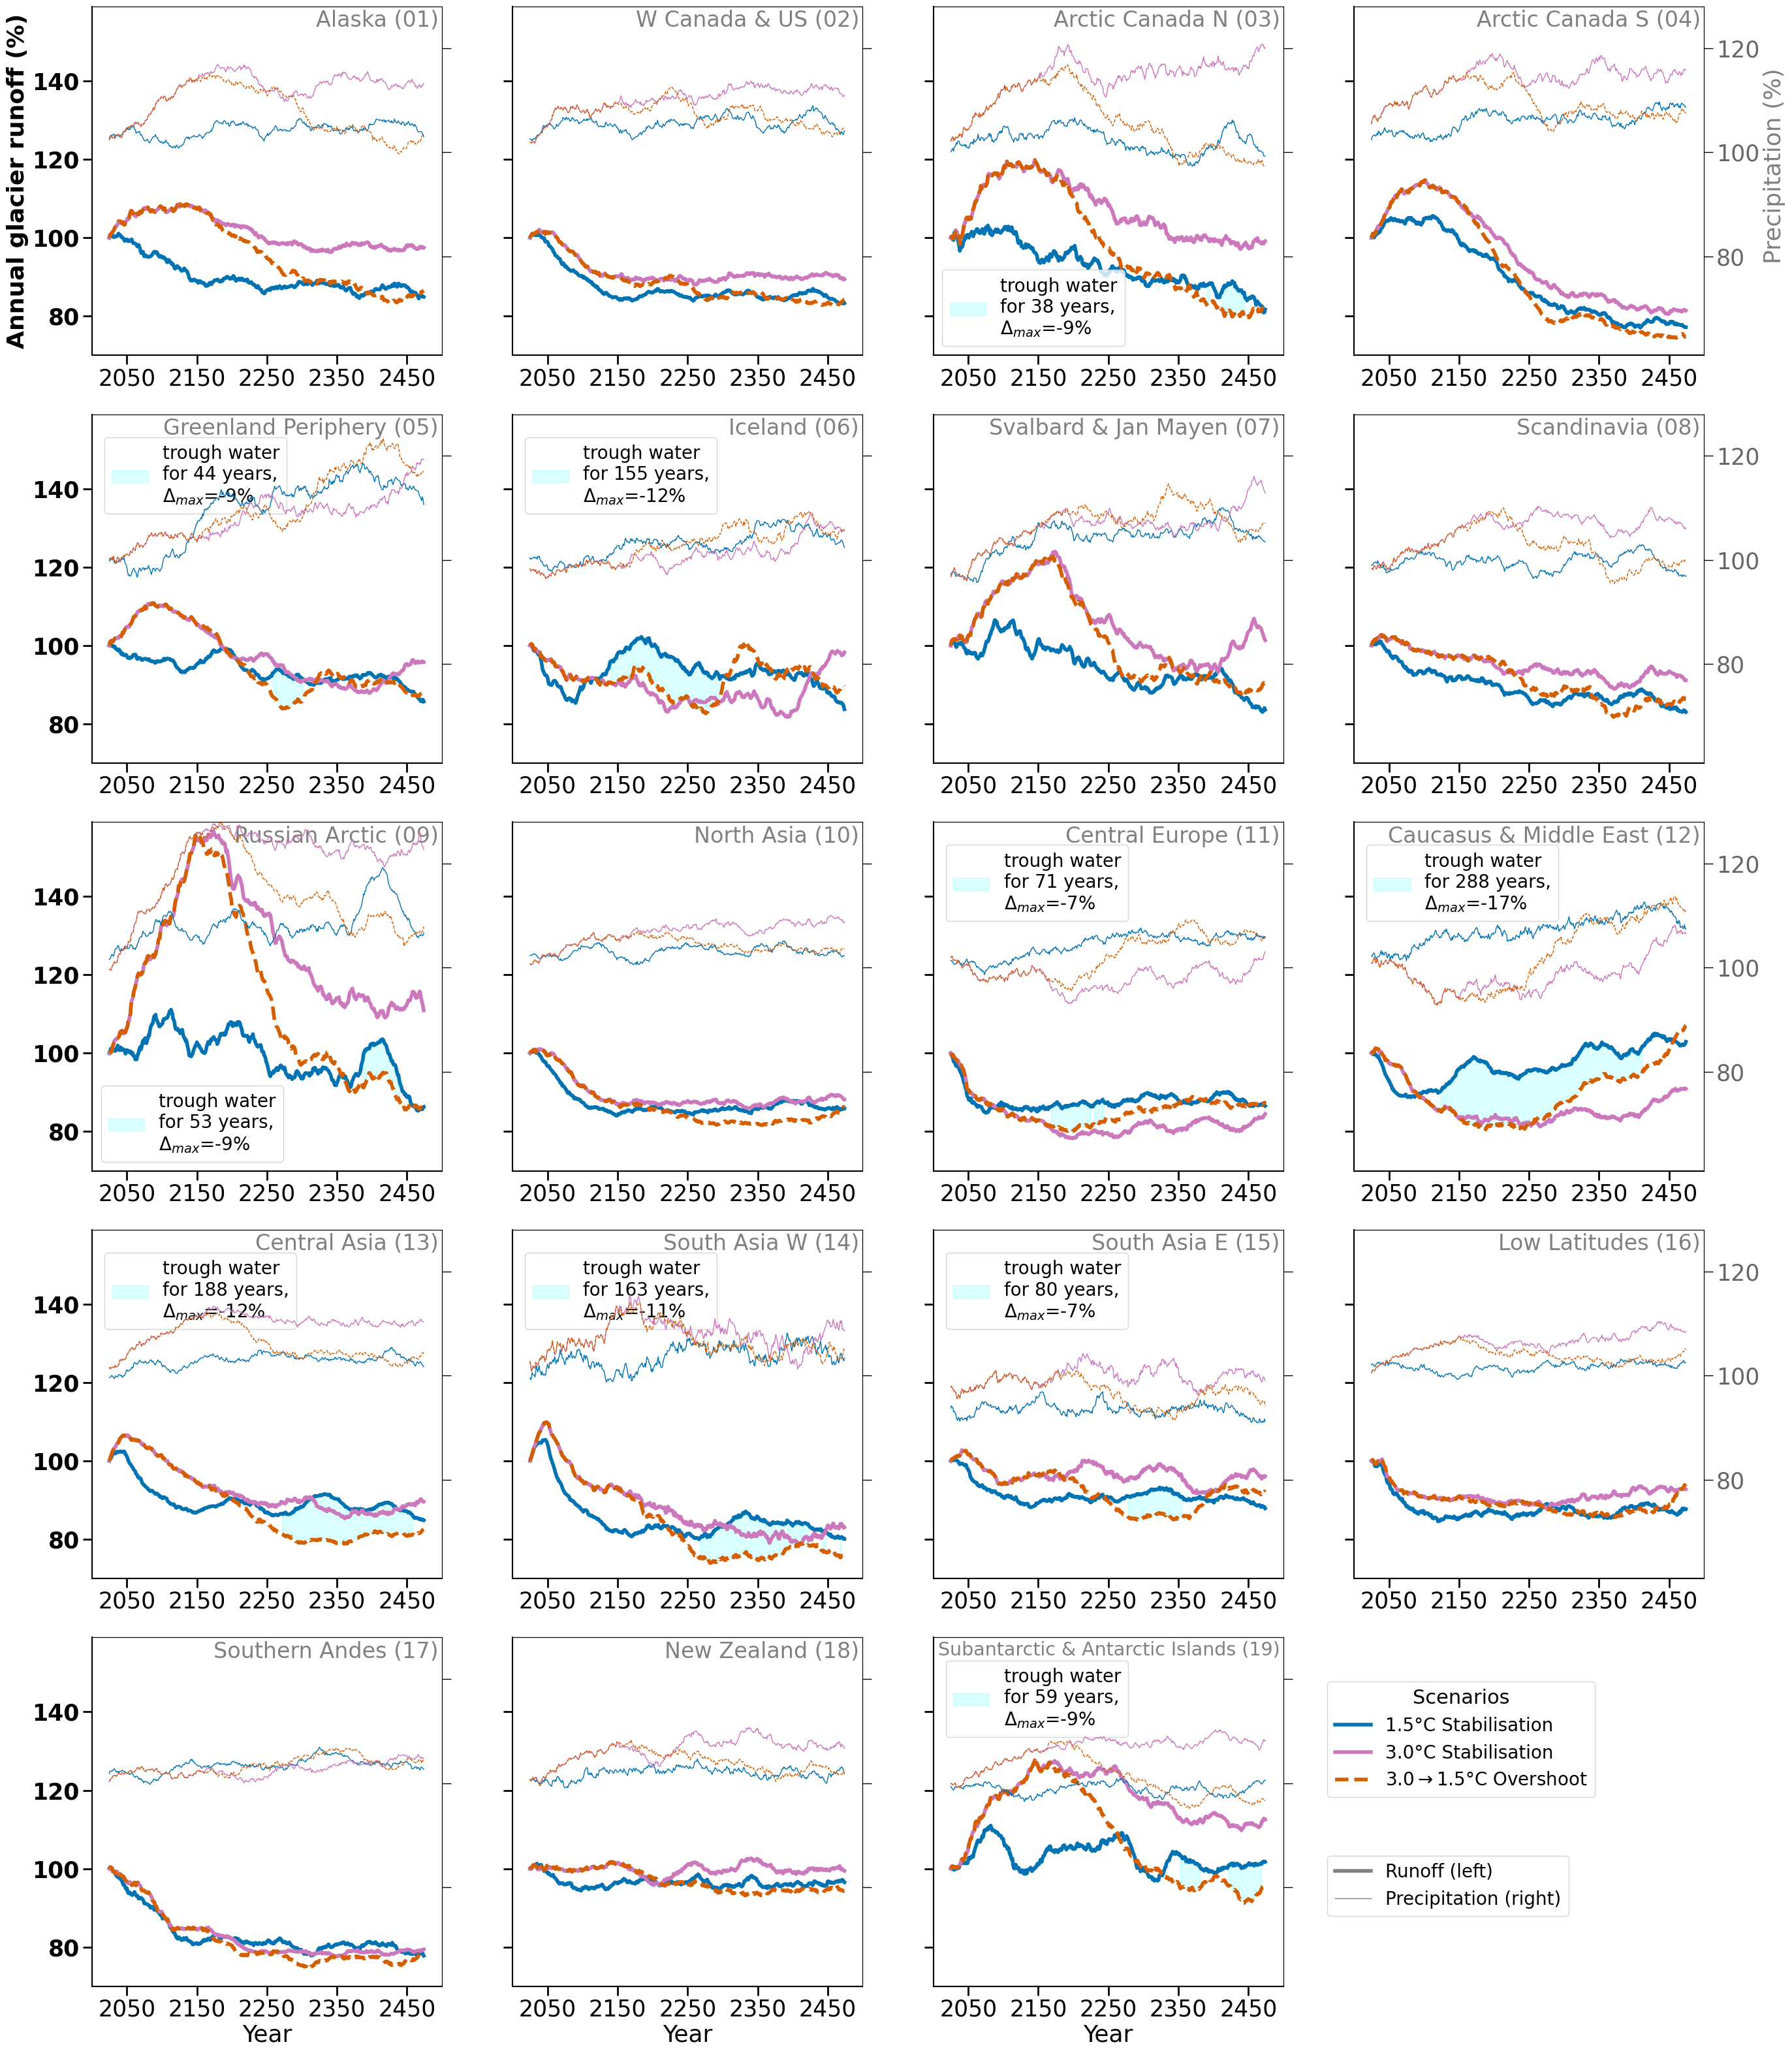

In [7]:
label_fs = 26
plt.rc('font', size=25)

var = 'precip_51yr_avg'
plt.figure(figsize=(28,32)) #, sharey=True, sharex=True)
for j, ri in enumerate(np.arange(1,20,1)):
    if ri<10:
        rgi_reg = f'0{ri}'
    else:
        rgi_reg = f'{ri}'
    pd_runoff_scenario_rel_reg_sel = pd_runoff_scenario_rel_reg.loc[pd_runoff_scenario_rel_reg.rgi_reg == rgi_reg]
    plt.subplot(5,4,ri)
    ax = plt.gca()
    ax2 = ax.twinx()  

    for scenario in scenarios:
        #ax.set_title('Globally')
        #plt.text(0.03,0.97, 'Globally',
        #         transform=ax.transAxes,ha='left',va='top',
        #         color='grey', fontsize=25)
        sns.lineplot(data=pd_runoff_scenario_rel_reg_sel.loc[pd_runoff_scenario_rel_reg_sel.scenario==scenario], 
                     x='time', y= 'runoff_rel_2000_2050_%', 
                     color=color_scenario_poster[scenario],
                     ls= scenario_ls[scenario],
                     lw=4, legend=True, ax = ax)

        pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario==scenario]
        pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == f'RGI{rgi_reg}_glacier']
        pd_clim_scenario_g.index = pd_clim_scenario_g.year
        temp_ref_g, precip_ref_g = pd_clim_scenario_g.loc[2000:2019][['temp','precip']].mean()
        var_g_to_ref = 100*pd_clim_scenario_g[var]/precip_ref_g

        ax2.plot(pd_clim_scenario_g.year,
                     var_g_to_ref,
                     alpha = 1, 
                     ls = scenario_ls[scenario],
                     lw=1, color = color_scenario[scenario], label=label_scenario[scenario])

    # overshoot runoff smaller than 0.95 times stabilisation runoff (both use 501r avg. runoff)
    sel_oversh = pd_runoff_scenario_rel_reg_sel.loc[pd_runoff_scenario_rel_reg_sel.scenario=='oversh_T30OS15']
    sel_stab = pd_runoff_scenario_rel_reg_sel.loc[pd_runoff_scenario_rel_reg_sel.scenario=='stab_T15']
    nyears, runoff_diff_trough, water_trough_min_yr, water_trough_max_diff, yrs_trough_pot_start_end = get_basin_trough_water_stats(sel_stab, sel_oversh, runoff_var ='runoff_rel_2000_2050_%')
    try:
        y0,y1 = yrs_trough_pot_start_end.split('_')
        sel_oversh.index = sel_oversh.time
        sel_stab.index = sel_stab.time
        water_trough_max_diff = np.round(float(water_trough_max_diff),0)
        add_label = f'for {int(nyears)} years,\n' + r'$\Delta_{max}$=-'+f'{int(water_trough_max_diff)}%'

        condi_5perc = (sel_oversh['runoff_rel_2000_2050_%']-sel_stab['runoff_rel_2000_2050_%']).loc[float(y0):float(y1)+1]<=-5
        # pd_basin_sel_oversh_T30OS15_runoff.loc[float(y0):float(y1)+1]['runoff_dry3m_rel_2000_2050_%'].where(condi_5perc)
        # important -> keep the NaNs to show the potential incontinuoties ... 
        ax.fill_between(sel_stab.loc[float(y0):float(y1)+1].time.where(condi_5perc),  
                         sel_stab.loc[float(y0):float(y1)+1]['runoff_rel_2000_2050_%'].where(condi_5perc), 
                         sel_oversh.loc[float(y0):float(y1)+1]['runoff_rel_2000_2050_%'].where(condi_5perc),
                         alpha = 0.15, color='cyan', zorder=-1, label='trough water\n'+add_label)
        handles_x, labels_x = ax.get_legend_handles_labels()
        if j in [2,8]:
            loc_leg3 = 'lower left'
            leg3 = ax.legend([handles_x[-1]], [labels_x[-1]], loc=loc_leg3,
                             fontsize=20)
        else:
            loc_leg3 = 'upper left'
            leg3 = ax.legend([handles_x[-1]], [labels_x[-1]], loc=loc_leg3,
                             bbox_to_anchor=(0.01,0.96),
                             fontsize=20)
    except AttributeError:
        pass
        
        
        
    ### ax
    if j>15:
        ax.set_xlabel('Year', fontsize=label_fs)
    else:
        ax.set_xlabel('')
    if j==0:
        ax.set_ylabel('Annual glacier runoff (%)', weight='bold', fontsize=label_fs)
    else:
        ax.set_ylabel('')
        
    if j in [0,4,8,12,16]:
        ax.set_yticks(ticks=np.arange(80,159,20),
                       labels=np.arange(80,159,20), weight='bold')
    else:
        ax.set_yticks(ticks=np.arange(80,159,20),
                       labels=np.arange(80,159,20), alpha = 0, fontsize=1)
    ax.set_ylim([70,159]);
    
    ax.set_xlim([2000,2500])
    ax.set_xticks([2050,2150,2250,2350,2450],[2050,2150,2250,2350,2450])
    for axis in 'left', 'bottom':
        ax.spines[axis].set_linewidth(1.5)
    ax.tick_params(axis='both', which='major', width=2, length=10,grid_alpha =0)

    # ax2
    ticks = np.arange(80,130,20)
    if j not in [3,7,11,15]:
        ax2.set_yticks(ticks=ticks,
                            labels=ticks, alpha=0, fontsize=1)
        plt.setp(ax2.get_yticklabels(), visible=False, fontsize=1)
    else:
        ax2.set_yticks(ticks=ticks,
                      labels=ticks,alpha = 0.6)
    
    ax2.set_ylim([61,128]);

    if j !=3:
        ax2.set_ylabel('')
    else:
        ax2.set_ylabel('    Precipitation (%)',color='grey', fontsize=label_fs)

    ax2.set_xlim([2000,2500])
    ax2.tick_params(axis='both', which='major', width=1, length=10, grid_alpha =0.6)
    
    if rgi_reg == '19':
        fs_reg = 20.5
    else:
        fs_reg = 24
    ax.text(0.99,0.99, d_reg_num_name[rgi_reg] + f' ({rgi_reg})',
             transform=ax.transAxes,ha='right',va='top',
             color='grey', fontsize=fs_reg)
plt.tight_layout()

handles_2, labels_2 = ax2.get_legend_handles_labels()
leg = ax.legend(handles_2[:len(scenarios)], 
                labels_2[:len(scenarios)], title='Scenarios', fontsize=20, title_fontsize=22, loc = 'upper left',
               bbox_to_anchor=(1.1,0.9))
for l in leg.get_lines():
    l.set_linewidth(4)
    
leg2 = ax.legend([handles_2[0], handles_2[0]], ['Runoff (left)',
                                              'Precipitation (right)'],
                 loc='upper left', ncol=1, fontsize=20,bbox_to_anchor=(1.1,0.4))
leg2.get_lines()[0].set_linewidth(4)
leg2.get_lines()[1].set_linewidth(1)
for l in leg2.get_lines():
    l.set_color('grey')
ax.add_artist(leg)
ax.add_artist(leg3)
plt.savefig('../figures/suppl_fig_RGIreg_runoff_prcp.pdf')